In [3]:
import tensorflow as tf
import requests
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from src.plotter.Plotter import Plotter
from src.maths.Error import r_squared

In [2]:
gpus = tf.config.list_physical_devices('GPU')

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=512)]
)

In [1]:
R = 8.31
M = 200.59e-3

critical_temperature = 1490+273.15
critical_pressure = 1510e5

In [4]:
data = requests.get('http://v5464.hosted-by-vdsina.com:8000/science/phases/?format=json').json()
temperature = np.array([dat['temperature'] for dat in data])
pressure = np.array([dat['pressure'] for dat in data])
density = np.array([dat['density'] for dat in data])

saturation_data = requests.get('http://v5464.hosted-by-vdsina.com:8000/science/saturations/?format=json').json()
saturation_temperature = np.array([dat['temperature'] for dat in saturation_data])
saturation_pressure = np.array([dat['pressure'] for dat in saturation_data])
saturation_density = np.array([dat['density'] for dat in saturation_data])

# pressure = np.log(pressure)
# density = np.log(density)

linearized_temperature = (temperature - min(temperature)) / (max(temperature) - min(temperature))
linearized_pressure = (pressure - min(pressure)) / (max(pressure) - min(pressure))
linearized_density = (density - min(density)) / (max(density) - min(density))

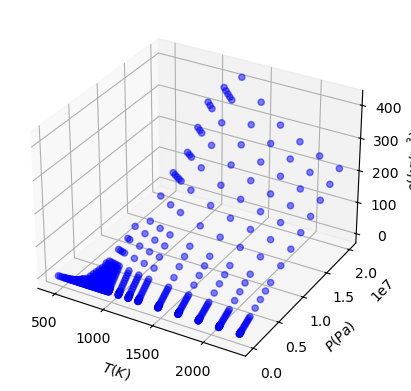

In [5]:
plotter = Plotter(dimension='3d')
plotter.scatter(temperature, pressure, density, color='b', alpha=0.5)
plotter.xlabel(r'$T(K)$')
plotter.ylabel(r'$P(Pa)$')
plotter.zlabel(r'$\rho (kg/m^3)$')
plotter.show()

In [6]:
inputs = tf.keras.layers.Input(shape=(2,))
x = tf.keras.layers.Dense(10, activation='relu')(inputs)
x = tf.keras.layers.Dense(10, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
    loss=tf.keras.losses.MSE,
)

In [10]:
mask = np.arange(len(linearized_temperature))
np.random.shuffle(mask)

x_train = np.array([linearized_temperature[mask], linearized_pressure[mask]]).T
y_train = np.array([linearized_density[mask]]).T

fit = model.fit(x_train, y_train, epochs=100, validation_split=0.2)

# with tf.device('/GPU:0'):
#     fit = model.fit(x_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
21/21 [==============================] - 0s 16ms/step - loss: 3.0577e-05 - val_loss: 3.0758e-05
Epoch 2/100
21/21 [==============================] - 0s 12ms/step - loss: 2.9016e-05 - val_loss: 2.9656e-05
Epoch 3/100
21/21 [==============================] - 0s 11ms/step - loss: 2.7598e-05 - val_loss: 3.3347e-05
Epoch 4/100
21/21 [==============================] - 0s 11ms/step - loss: 2.8364e-05 - val_loss: 3.9416e-05
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 2.9064e-05 - val_loss: 3.1209e-05
Epoch 6/100
21/21 [==============================] - 0s 10ms/step - loss: 2.8791e-05 - val_loss: 3.2226e-05
Epoch 7/100
21/21 [==============================] - 0s 9ms/step - loss: 3.0544e-05 - val_loss: 3.6814e-05
Epoch 8/100
21/21 [==============================] - 0s 10ms/step - loss: 2.6803e-05 - val_loss: 3.0403e-05
Epoch 9/100
21/21 [==============================] - 0s 10ms/step - loss: 2.5911e-05 - val_loss: 3.0056e-05
Epoch 10/100
21/21 [=========

In [23]:
x_test = np.array([linearized_temperature, linearized_pressure]).T
y_test = model.predict(x_test).T

r = r_squared(y_test, density)
r = np.round(r, 4)

plotter = Plotter(dimension='3d')
plotter.scatter(linearized_temperature, linearized_pressure, linearized_density, color='b', label='Experimental data')
plotter.scatter(linearized_temperature, linearized_pressure, y_test, color='r', label=rf'Network data, $R^2={r}$')
plotter.xlabel(r'$T_n$')
plotter.ylabel(r'$p_n$')
plotter.zlabel(r'$\rho_n$')
plotter.legend()
plotter.show()

# linear_x = np.linspace(0, 1, 100)
# linear_y = linear_x
# 
# plotter = Plotter(dimension='2d')
# plotter.scatter(linearized_density, y_test, alpha=0.5)
# plotter.plot(linear_x, linear_y, 'b-')
# plotter.xlabel(r'$Experimental$ $data$')
# plotter.ylabel(r'$Predicted$ $data$')
# plotter.grid(True)
# plotter.show()

27/27 [==============================] - 0s 2ms/step


<h2 align='center'>Mass difference in Equation of state</h2>

In [34]:
Z = pressure * M / (R * temperature)

sort_mask = np.lexsort((temperature, pressure, density))
mask1 = (density < 200) & (density > 0)
mask2 = (density < 2000) & (density > 200)

lin_func_1 = lambda x, a: a * x
lin_func_2 = lambda x, a, b: a * x + b
lin_popt_1, _ = curve_fit(lin_func_1, density[mask1], Z[mask1])
lin_popt_2, _ = curve_fit(lin_func_2, density[mask2], Z[mask2])
lin_popt_1 = np.round(lin_popt_1, 4)
lin_popt_2 = np.round(lin_popt_2, 4)

par_func_1 = lambda x, a: a * x ** 2 + x
par_popt_1, _ = curve_fit(par_func_1, density, Z)
par_popt_1 = np.round(par_popt_1, 4)

# func = lambda x, a, b: a * x + b
# func2 = lambda x, a, b, c: a * x ** 2 + b * x + c
# test_func = lambda x: -25/1e5 * x ** 2 + x
# test_func2 = lambda x, a, b, c: a * np.log(x + b) + c
# popt1, pcov1 = curve_fit(func, density[mask1], Z[mask1])
# popt2, pcov2 = curve_fit(func, density[mask2], Z[mask2])
# popt3, pcov3 = curve_fit(func2, density[sort_mask], Z[sort_mask])
# popt4, pcov4 = curve_fit(test_func2, density[sort_mask], Z[sort_mask])

In [35]:
def equation_of_state_1(x):
    return x[x <= 200] - (lin_popt_2[0] * x[x >= 200] + lin_popt_2[1])

def equation_of_state(x):
    return x + np.tanh(x / 200)*((lin_popt_2[0] - 1) * x + lin_popt_2[1])

In [45]:
plt.figure()
plotter = Plotter(dimension='2d')
plotter.scatter(density, Z, color='b', alpha=0.5)

# x = density[mask1]
# y = lin_func_1(x, *lin_popt_1)
# r = r_squared(y, Z[mask1])
# r = np.round(r, 5)
# plotter.plot(x, y,'r-',label=rf'$y_1={lin_popt_1[0]} \bullet x$, $R^2={r}$')
# 
# x = density[mask2]
# y = lin_func_2(x, *lin_popt_2)
# r = r_squared(y, Z[mask2])
# r = np.round(r, 5)
# plotter.plot(x, y, 'g-', label=rf'$y_2={lin_popt_2[0]} \bullet x + {lin_popt_2[1]}$, $R^2={r}$')

x = density[sort_mask]
y = par_func_1(x, *par_popt_1)
r = r_squared(y, Z[sort_mask])
r = np.round(r, 5)
plotter.plot(x, y, 'r-', label=rf'$y_3={par_popt_1[0]} \bullet x^2 + x$, $R^2={r}$')

# plotter.plot(
#     density[sort_mask], 
#     equation_of_state(density[sort_mask]),
#     'c-', 
#     label='Our equation of state'
# )

plotter.xlabel(r'$\rho (kg/m^3)$')
plotter.ylabel(r'$\frac{pM}{RT} (kg/m^3)$')
plotter.legend(edgecolor='k')
plotter.grid(True)
plotter.show()

<h2 align='center'>The transponse line</h2>

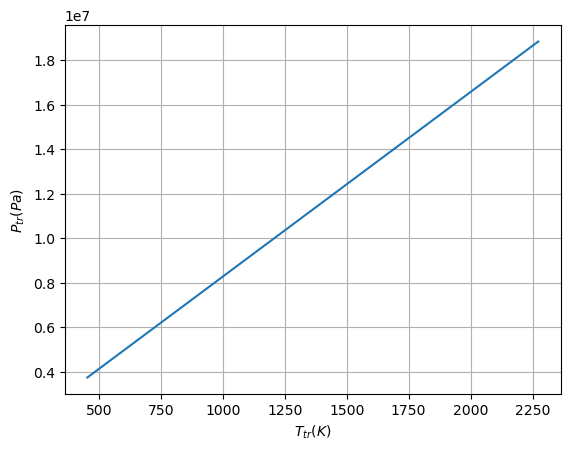

In [8]:
p_tr = 200 * R * temperature / M

plotter = Plotter(dimension='2d')
plotter.plot(temperature, p_tr)
plotter.xlabel(r'$T_{tr} (K)$')
plotter.ylabel(r'$P_{tr} (Pa)$')
plotter.grid(True)
plotter.show()

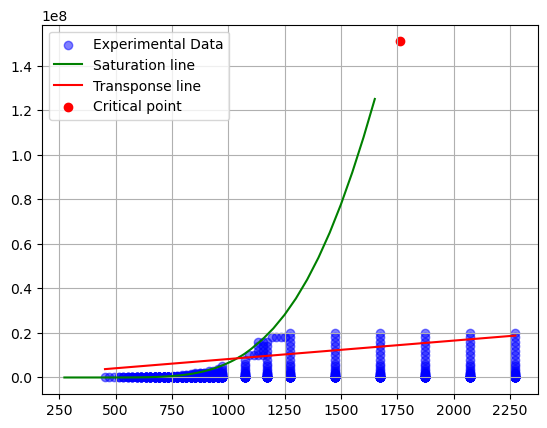

In [9]:
sort_mask = np.lexsort((temperature, pressure))
saturaion_sort_mask = np.lexsort((saturation_temperature, saturation_pressure))

plotter = Plotter(dimension='2d')
plotter.scatter(temperature[sort_mask], pressure[sort_mask], color='b', alpha=0.5, label='Experimental Data')
plotter.plot(saturation_temperature[saturaion_sort_mask], saturation_pressure[saturaion_sort_mask], 'g-', label='Saturation line')
plotter.plot(temperature, p_tr, 'r-', label='Transponse line')
plotter.scatter(1490+273.15, 1510e5, color='r', label='Critical point')
plotter.grid(True)
plotter.legend()
plotter.show()

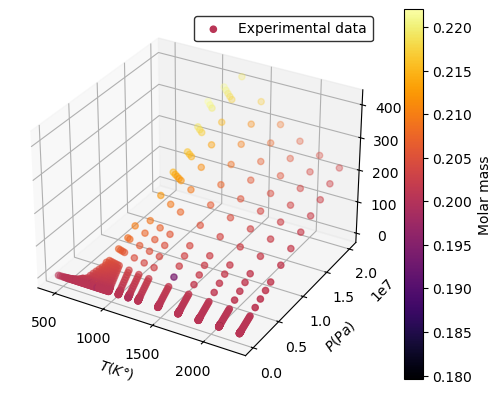

In [10]:
temp = R * temperature * density / pressure

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(temperature, pressure, density, c=temp, cmap='inferno', label='Experimental data')
ax.legend(edgecolor='k')
ax.set_xlabel(r'$T (K \degree)$')
ax.set_ylabel(r'$P (Pa)$')
ax.set_zlabel(r'$\rho (kg/m^3)$')
plt.colorbar(scatter, label='Molar mass')
plt.show()

<h2 align='center'>$M(\rho)$</h2>

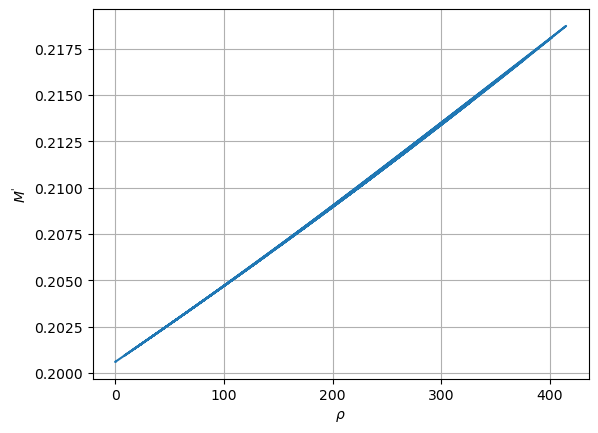

In [11]:
plotter = Plotter(dimension='2d')
plotter.plot(density[sort_mask], M / (par_popt_1[0] * density[sort_mask] + 1))
plotter.xlabel(r'$\rho$')
plotter.ylabel(r"$M^'$")
plotter.grid(True)
plotter.show()

<h2 align='center'> The saturation line</h2>

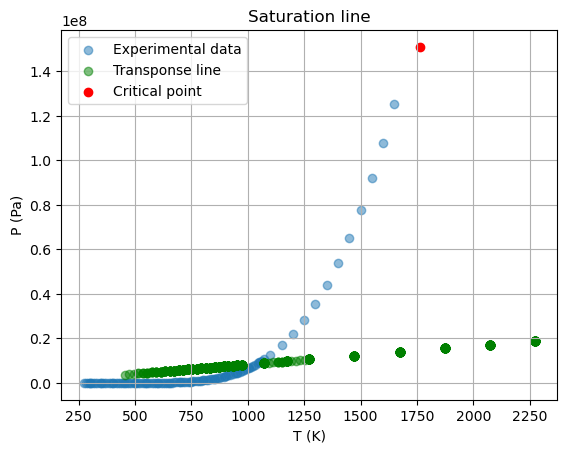

In [12]:
plotter = Plotter(dimension='2d')
plotter.title('Saturation line')
plotter.scatter(saturation_temperature, saturation_pressure, alpha=0.5, label='Experimental data')
plotter.scatter(temperature, p_tr, color='g', alpha=0.5, label='Transponse line')
plotter.scatter(1490+273.15, 1510e5, color='r', label='Critical point')
plotter.xlabel('T (K)')
plotter.ylabel('P (Pa)')
plotter.grid(True)
plotter.legend()
plotter.show()

In [55]:
def saturation_func(x, a, b):
    return a * x + b


def saturation_line(tau, a_1, a_2, a_3, a_4, a_5, a_6):
    return 1/tau * (a_1 * (1-tau) + a_2 * (1-tau) ** 1.5 + a_3 * (1-tau) ** 3 + a_4 * (1-tau) ** 3.5 + a_5 * (1-tau) ** 4 + a_6 * (1-tau) ** 7.5)


saturation_sort_mask = np.lexsort((saturation_temperature, saturation_pressure, saturation_density))

tau = saturation_temperature / critical_temperature
pheta = saturation_pressure / critical_pressure
sat_popt, sat_pcov = curve_fit(saturation_line, tau, np.log(pheta))
print(sat_popt)

adjusted_saturation_temperature = critical_temperature / saturation_temperature
adjusted_saturation_pressure = saturation_pressure / critical_pressure

saturation_popt, saturation_pcov = curve_fit(saturation_func, adjusted_saturation_temperature, np.log(adjusted_saturation_pressure))
saturation_popt = np.round(saturation_popt, 2)


saturation_temperature_lin = np.linspace(270, critical_temperature, 100)

plotter = Plotter(dimension='2d')
plotter.scatter(saturation_temperature, saturation_pressure, alpha=0.5, label='Experimental data')

x = saturation_temperature_lin
y = np.exp(saturation_func(critical_temperature/saturation_temperature_lin, *saturation_popt)) * critical_pressure
y_1 = np.exp(saturation_func(critical_temperature/saturation_temperature, *saturation_popt)) * critical_pressure
r = r_squared(y_1, saturation_pressure)
r = np.round(r, 4)
plotter.plot(x, y, 'r--', label=fr'Our equation $R^2={r}$')

x = saturation_temperature_lin
y = np.exp(saturation_line(saturation_temperature_lin / critical_temperature, *sat_popt)) * critical_pressure
y_1 = np.exp(saturation_line(saturation_temperature / critical_temperature, *sat_popt)) * critical_pressure
r = r_squared(y_1, saturation_pressure)
r = np.round(r, 4)
plotter.plot(x, y, 'b-', label=fr'Known equation $R^2={r}$')

plotter.scatter(critical_temperature, critical_pressure, color='r', label='Critical point')
plotter.xlabel('$T(K)$')
plotter.ylabel('$P(Pa)$')
plotter.legend()
plotter.grid(True)
plotter.show()

[  -0.67720295   -9.69409424   64.75474773 -107.20004043   49.77182408
   -1.28959448]


In [73]:
plotter = Plotter(dimension='2d')
plotter.scatter(critical_temperature, critical_pressure, color='r', label='Critical point')
plotter.scatter(temperature, pressure, color='b', alpha=0.5, label='Experimental data')
plotter.plot(saturation_temperature_lin, np.exp(saturation_line(saturation_temperature_lin / critical_temperature, *sat_popt)) * critical_pressure, 'k-', label='Saturation line')
plotter.grid(True)
plotter.xlabel('$T(K)$')
plotter.ylabel('$P(Pa)$')
plotter.legend()
plotter.show()

AttributeError: 'Plotter' object has no attribute 'text'

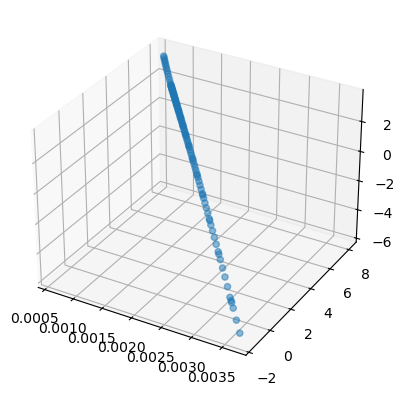

In [14]:
plotter = Plotter(dimension='3d')
plotter.scatter(1/saturation_temperature, np.log10(saturation_pressure), np.log10(saturation_density), alpha=0.5)
plotter.show()

<h2 align='center'>Known equation of saturation line</h2>

In [47]:
saturation_sort_mask = np.lexsort((saturation_temperature, saturation_pressure, saturation_density))
critical_temperature = 1490+273.15
critical_pressure = 1510e5

def saturation_line(tau, a_1, a_2, a_3, a_4, a_5, a_6):
    return 1/tau * (a_1 * (1-tau) + a_2 * (1-tau) ** 1.5 + a_3 * (1-tau) ** 3 + a_4 * (1-tau) ** 3.5 + a_5 * (1-tau) ** 4 + a_6 * (1-tau) ** 7.5)


tau = saturation_temperature / critical_temperature
pheta = saturation_pressure / critical_pressure
sat_popt, sat_pcov = curve_fit(saturation_line, tau, np.log(pheta))
print(sat_popt)


plotter = Plotter(dimension='2d')
plotter.scatter(critical_temperature, critical_pressure, color='r', label='Critical point')
plotter.scatter(saturation_temperature, saturation_pressure, color='b', alpha=0.5, label='Experimental data')
plotter.plot(saturation_temperature[saturation_sort_mask], np.exp(saturation_line(tau[saturation_sort_mask], *sat_popt)) * critical_pressure, label='Saturation equation')
plotter.xlabel(r'$T(K)$')
plotter.ylabel(r'$P(Pa)$')
plotter.legend()
plotter.grid(True)
plotter.show()


[  -0.67720295   -9.69409424   64.75474773 -107.20004043   49.77182408
   -1.28959448]


In [48]:
derived_temperature = saturation_temperature / critical_temperature
derived_pressure = saturation_pressure / critical_pressure

plotter = Plotter(dimension='2d')
plotter.scatter(1/derived_temperature, np.log(derived_pressure), color='b', alpha=0.5, label='Experimental data')
plotter.scatter(1, 0, color='r', alpha=0.5, label='Critical point')
plotter.xlabel(r'$\frac{T_c}{T}$')
plotter.ylabel(r'$ln(\frac{p}{p_c})$')
plotter.legend()
plotter.grid(True)
plotter.show()

<h2 align='center'>State</h2>

In [65]:
def plane(xy, A, B, C):
    x, y = xy
    return A*x + B*y + C


temperature_log = np.log(temperature)
pressure_log = np.log(pressure)
density_log = np.log(density)

plane_popt, plane_pcov = curve_fit(plane, (temperature_log, pressure_log), density_log)
plane_x = np.linspace(min(temperature_log), max(temperature_log), 100)
plane_y = np.linspace(min(pressure_log), max(pressure_log), 100)
plane_x, plane_y = np.meshgrid(plane_x, plane_y)
plane_z = plane((plane_x, plane_y), *plane_popt)


plotter = Plotter(dimension='3d')
plotter.scatter(np.log(temperature), np.log(pressure), np.log(density), color='b', alpha=1, label=fr'Experimental data')

r = r_squared(plane((temperature_log, pressure_log), *plane_popt), density_log)
r = np.round(r, 4)
plotter.plot_wireframe(plane_x, plane_y, plane_z, color='m', label=fr'Equation of state, $R^2={r}$')

plotter.xlabel(r'$ln(T)$')
plotter.ylabel(r'$ln(P)$')
plotter.zlabel(r'$ln(\rho)$')
plotter.legend()
plotter.show()

In [66]:
plotter = Plotter(dimension='3d')
plotter.scatter(temperature, pressure, density, color='b', alpha=1, label=fr'Experimental data')

r = r_squared(plane(np.exp((temperature_log, pressure_log)), *plane_popt), density)
r = np.round(r, 4)
plotter.plot_wireframe(np.exp(plane_x), np.exp(plane_y), np.exp(plane_z), color='m', label=fr'Equation of state, $R^2={r}$')

plotter.xlabel(r'$T(K)$')
plotter.ylabel(r'$P(Pa)$')
plotter.zlabel(r'$\rho(kg/m^3)$')
plotter.legend()
plotter.show()

<h2 align='center'>Viral equation of state</h2>

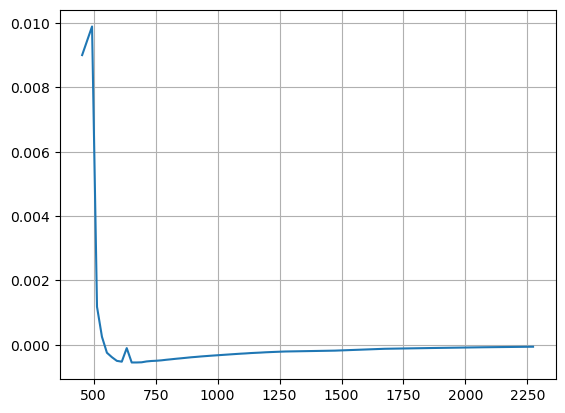

In [23]:
def viral_equation(x, b_2):
    return x + b_2 * x ** 2


temperature_set = sorted(set(temperature))
popt = [None] * len(temperature_set)
i = -1
for temp in temperature_set:
    i += 1
    temp_mask = (temperature == temp)
    temp_temperature = temperature[temp_mask]
    temp_pressure = pressure[temp_mask]
    temp_density = density[temp_mask]
    # 
    # if len(temp_temperature) < 2:
    #     continue
    
    temp_Z = temp_pressure * M / (R * temp_temperature)
    
    popt[i] = curve_fit(viral_equation, temp_density, temp_Z)[0][0]
    
plotter = Plotter(dimension='2d')
plotter.plot(temperature_set, popt)
plotter.grid(True)
plotter.show()

<h2 align='center'>Matplotlib settings</h2>

In [21]:
%matplotlib inline

In [14]:
%matplotlib qt

In [106]:
print(plane_popt)

[-1.00730751  1.00446963 -3.72152391]
